In [1]:
import numpy as np
from numba import njit
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import pickle
from datetime import datetime,timedelta, date
import strax
import straxen
import cutax
from tqdm.notebook import tqdm, trange
strax.utils.tqdm = tqdm
from multihist import Hist1d, Histdd

import copy
from matplotlib import cm
from scipy import stats
import feldman_cousins as fc
from scipy.stats import poisson
from scipy.optimize import minimize, rosen, rosen_der
import h5py

import GOFevaluation as ge
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
import os
style = os.path.join(os.environ['HOME'], 'nton/mplconfigs/stylelib/xenonnt.mplstyle')   
plt.style.use(style)

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 9

In [5]:
%run -i 'YBe_tool.py'
%run -i 'stuff_to_load.py'
mode='3-fold'
# mode='2-fold-only'

In [6]:
Y88_hl=106.6
kbq_initial=698
kbq_sim=389
day_lapse=-np.log(kbq_sim/kbq_initial)/np.log(2)*Y88_hl
#2022-6-1 initial date
source_date=datetime(2022,6,1)+timedelta(days=day_lapse)
dt=(datetime(2022,10,5)-source_date)/timedelta(days=1)

In [7]:
hour=183.78

# gamma_ineff=0.9 #NR inefficincy due to gamma coincident
# start_to_mid=0.9809

gamma_ratio=0.93356 #gamma ratio between YBe and Y88 run
# one_week_decay=np.exp(-7/(Y88_hl/np.log(2))) #fitted source decay rate

# sim_ratio=1/(start_to_mid*one_week_decay**2) #old scaling
sim_ratio=1/(np.exp(-dt/(Y88_hl/np.log(2)))) #new scaling

s_hour=15393*sim_ratio #hours of simulation, in the same rate as YBe run
b_hour=142.21*gamma_ratio #hours of background run, in the rate, in the same rate as YBe run
y_hour=365*24
bkg_s=hour/b_hour #pre-scaling for Y88 
sim_s=hour/s_hour #pre-scaling for YBe simulation

In [8]:
# data_cuts=pd.read_hdf("good_data.hdf5")
bkg=pd.read_hdf("/project2/lgrandi/dali/sghosh/Y88_event_info_143runs_142.21hrs_all_cuts_with_run_ids_v2.hdf5")
data=pd.read_hdf("/project2/lgrandi/dali/sghosh/YBe_event_info_239runs_183.78hrs_all_cuts_with_run_ids_v2.hdf5")

sim_raw=pd.read_csv("/project2/lgrandi/ghusheng/YBe_sim/ybeneu_low_event_info.csv")
sim_highE=pd.read_csv("/project2/lgrandi/scli/data/ybeneu_high_event_info.csv")



In [9]:
# df_0 = pd.read_csv('/project2/lgrandi/scli/data/ybe_neutron_nr_event_info.csv')

In [14]:
def get_entry(df):
    return int((max(df.time)-min(df.time))/1e9)


In [15]:
mode='3-fold'

In [16]:
#quality cuts 3fold
if mode=='3-fold':
    ac_h5 = '/project2/lgrandi/ghusheng/YBe_sim/ac_ybe_0109.h5'

    with h5py.File(ac_h5, 'r', libver='latest', swmr=True) as ipt:
        normalization = ipt['fold3_df'].attrs['normalization']

    ac_sim = pd.read_hdf(ac_h5, key='fold3_df', columns=['cs1', 'cs2', 'cut_fiducial_volume', 'cut_near_wires','x','y','r','z'])
    data_cuts = data.query(' and '.join(targets_3fold[1:]))
    bkg_cuts = bkg.query(' and '.join(targets_3fold[1:]))
    sim = sim_raw.query(' and '.join(targets_3fold[1:]))
    ac_sim_cuts = ac_sim[ac_sim.cut_fiducial_volume]
    s1_bins=np.linspace(2.5,20.5,19)
    # del bkg
    # del data
    # del sim_raw

In [17]:
sim_high = sim_highE.query(' and '.join(targets_3fold[1:]))

In [74]:
#real ACs
bkg_clean=wire_cut(df_cut_SA(bkg_cuts))

In [18]:
#get ac temp with wire FV cuts
ac_sample_to_fit=ac_sim[(ac_sim.cut_fiducial_volume==True)&(ac_sim.cut_near_wires==False)]

In [23]:
sim_high=wire_cut(sim_high)
data_cuts = wire_cut(data_cuts)
bkg_cuts = wire_cut(bkg_cuts)
sim = wire_cut(sim)


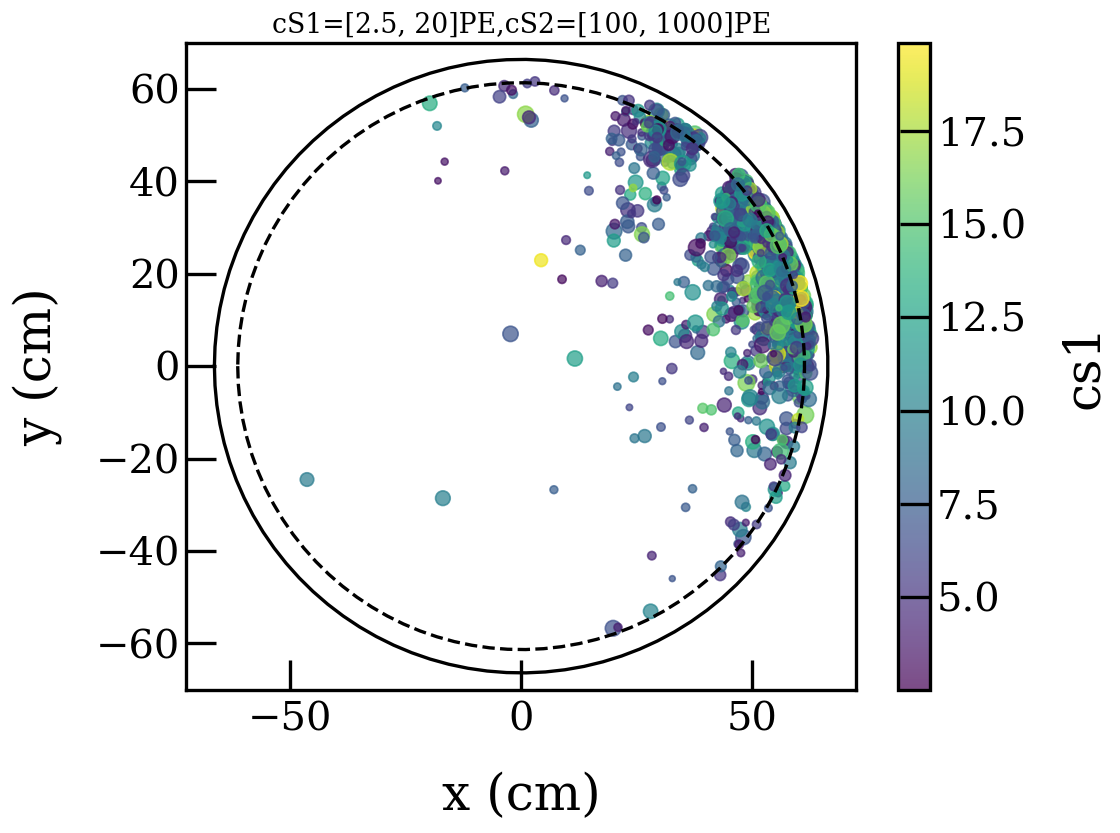

In [24]:
#check xy
cs1_range=[2.5,20]
cs2_range=[100,1000]
plot_xy(cut_cs1cs2(sim_high[:2000],cs1=cs1_range,cs2=cs2_range),cs1_range,cs2_range)

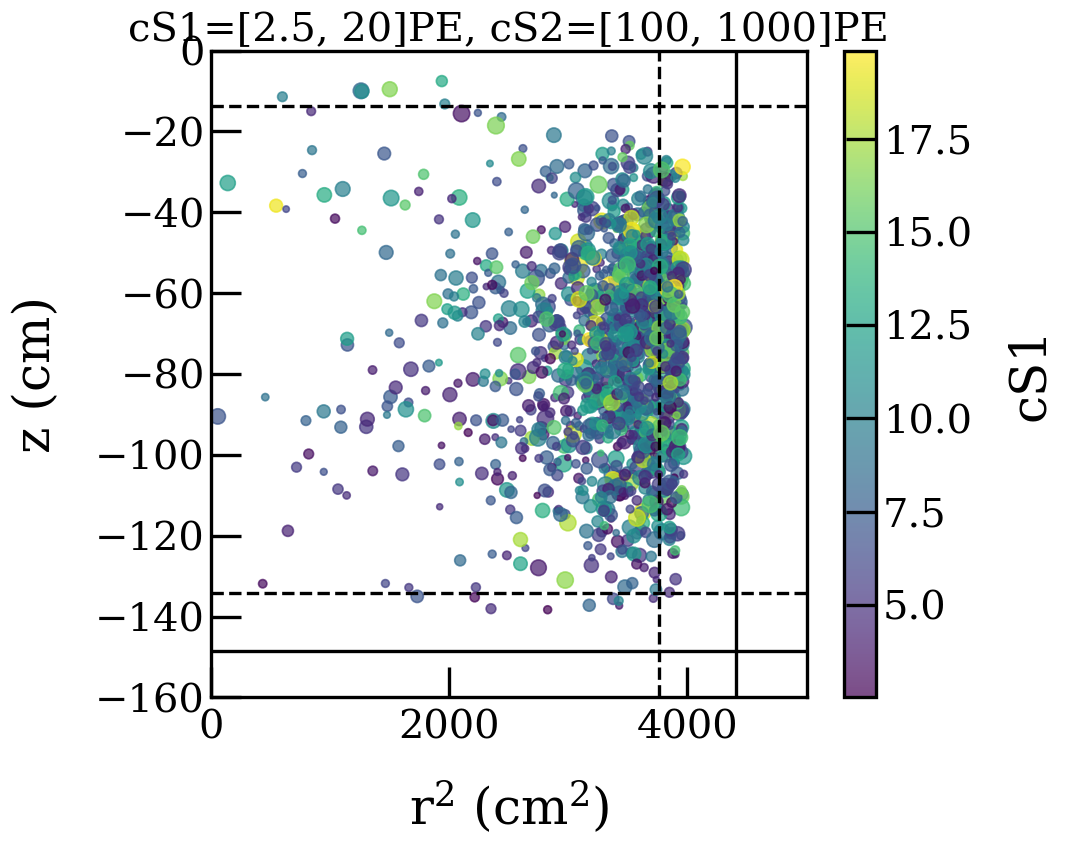

In [25]:
#check xy
cs1_range=[2.5,20]
cs2_range=[100,1000]
plot_rz(cut_cs1cs2(sim_high[:2000],cs1=cs1_range,cs2=cs2_range),cs1_range,cs2_range)

In [27]:
AC_hour=1/normalization*365*24

In [54]:
len(ac_sample_to_fit)*bkg_sim_s

97.13502117292784

In [75]:
#branching ratio
br=0.0071

In [80]:
print('expected highE:')
sim_s*len(cut_cs1cs2(sim_high,cs1=[2.5,20],cs2=[200,600]))*br

expected highE:


4.811026741154654

In [81]:
print('events number from data:')
len(cut_cs1cs2(data_cuts,cs1=[2.5,20],cs2=[200,600]))

events number from data:


226

In [82]:
print('expeted lowE:')
sim_s*len(cut_cs1cs2(sim,cs1=[2.5,20],cs2=[200,600]))

expeted lowE:


189.23775653953007

In [34]:
import GOFevaluation as ge
data_sample=cut_cs1cs2(data_cuts,cs1=[2.5,20],cs2=[200,600])
reference_sample=cut_cs1cs2(sim,cs1=[2.5,20],cs2=[200,600])

data_sample=np.array(data_sample[['cs1','cs2']])
reference_sample=np.array(reference_sample[['cs1','cs2']])
ref_model_0=reference_sample

In [38]:
sim_high_scale=get_random(sim_high,int(len(sim_high)*br))

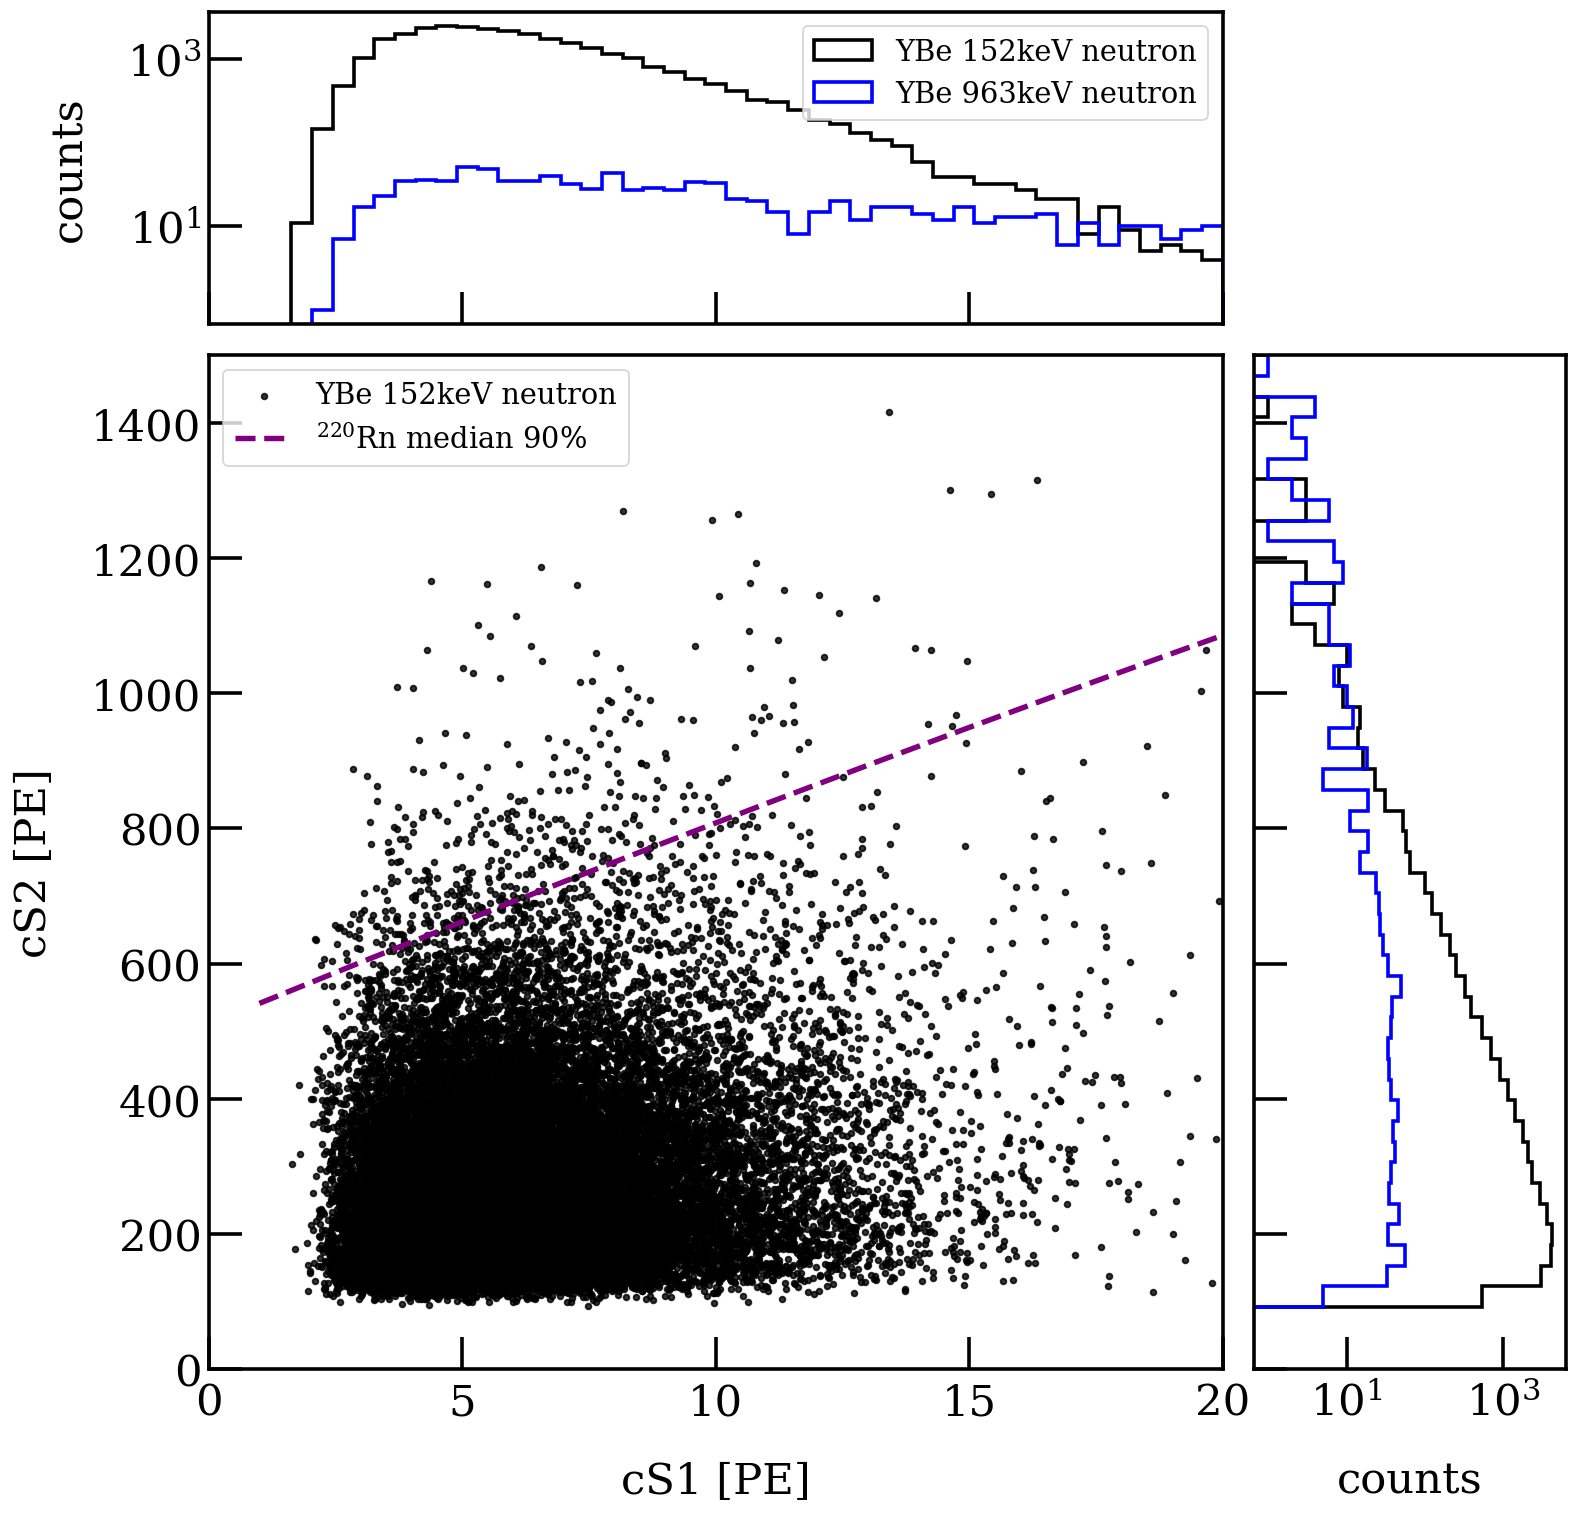

(<Axes:xlabel='cS1 [PE]', ylabel='cS2 [PE]'>,
 <Axes:ylabel='counts'>,
 <Axes:xlabel='counts'>)

In [45]:
plot_cs1cs2(sim,df_sim=sim_high_scale,data_label=f'YBe 152keV neutron',sim_label=f'YBe 963keV neutron')

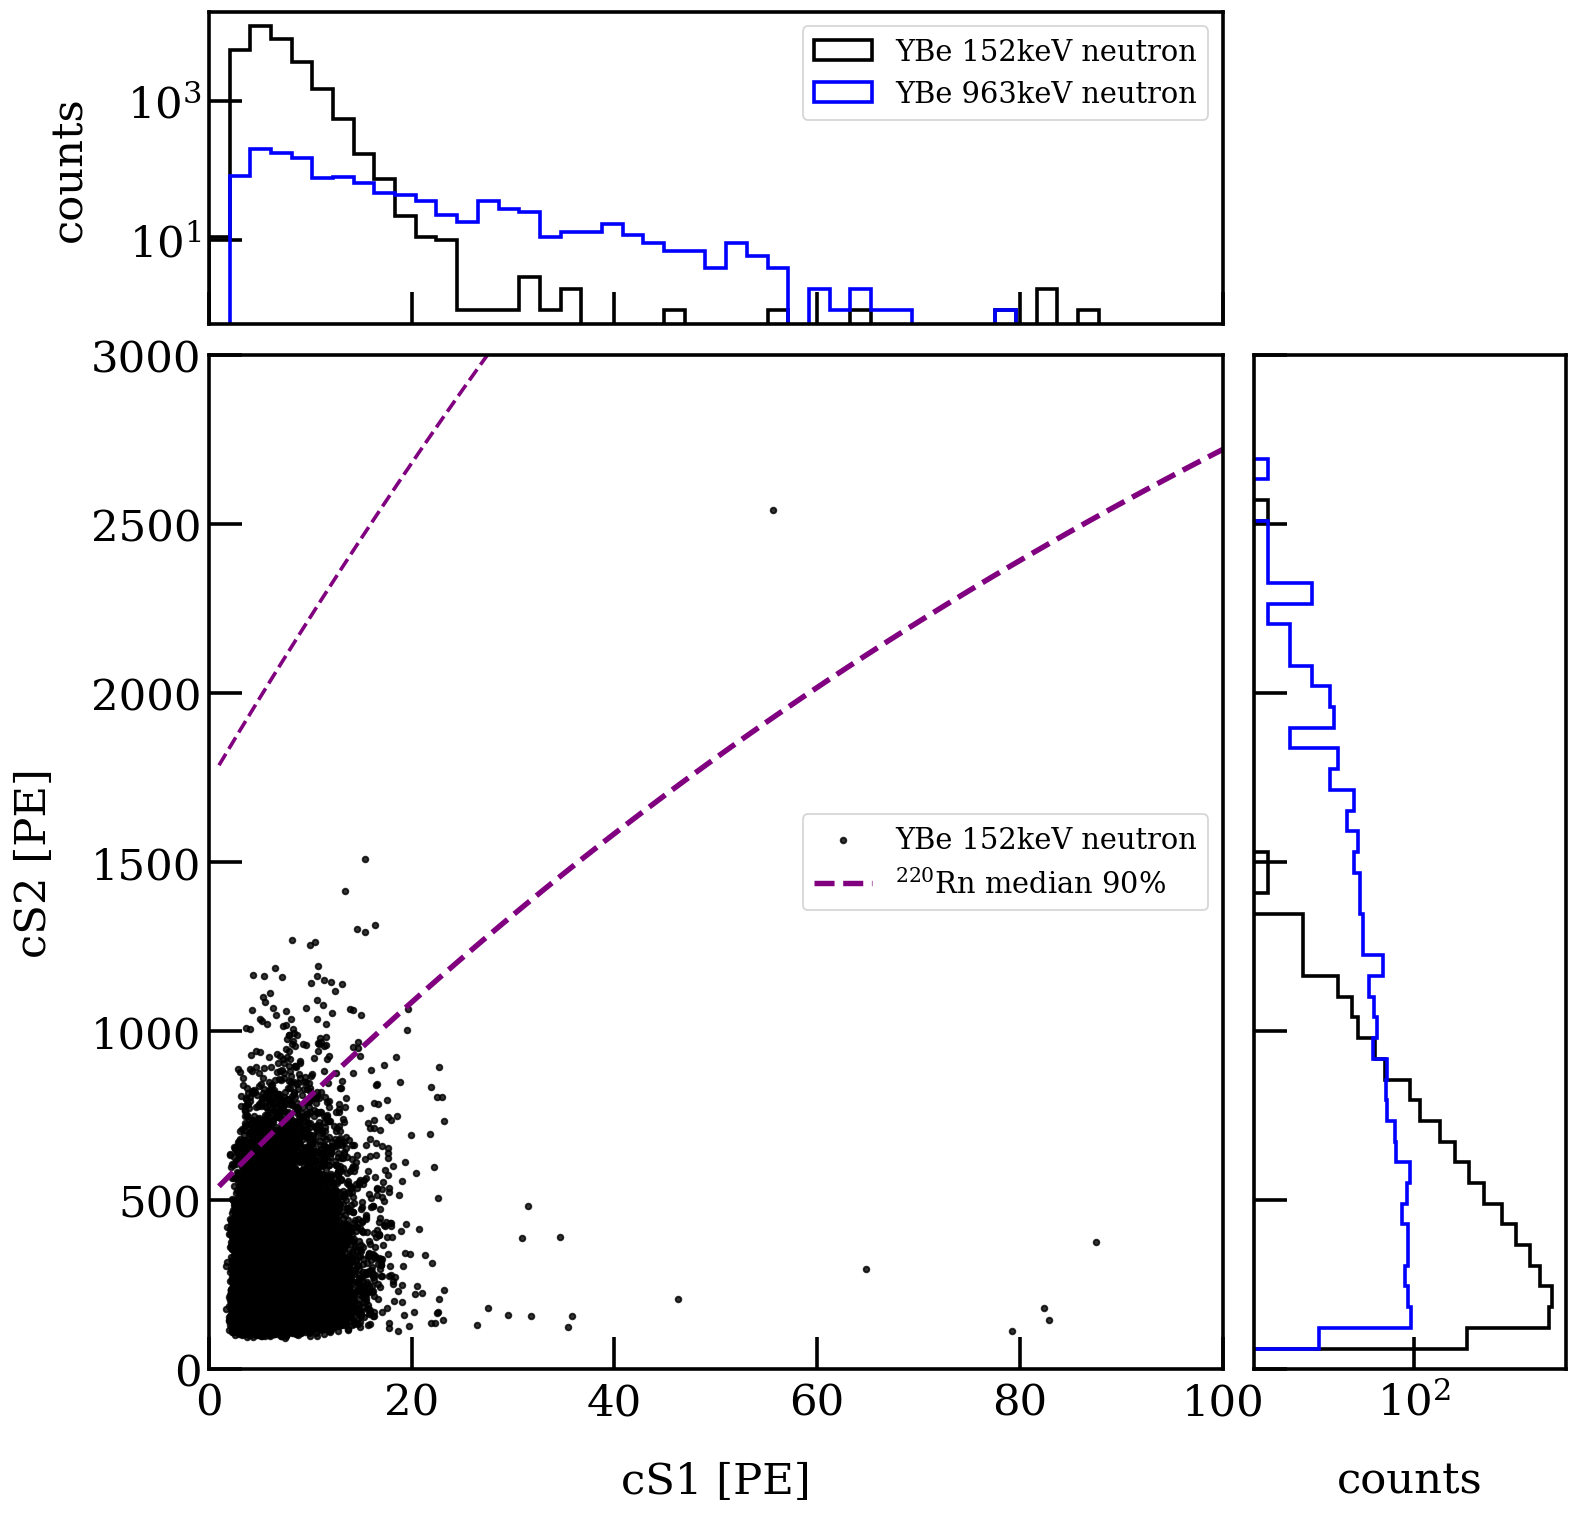

(<Axes:xlabel='cS1 [PE]', ylabel='cS2 [PE]'>,
 <Axes:ylabel='counts'>,
 <Axes:xlabel='counts'>)

In [85]:
plot_cs1cs2(sim,df_sim=sim_high_scale,data_label=f'YBe 152keV neutron',sim_label=f'YBe 963keV neutron',xlim=[0,100],ylim=[0,3000])

In [47]:
sim_mixed=pd.concat([sim, sim_high_scale])

117 120.30128011526557
GOF = 46.75
p-value = 0.1880



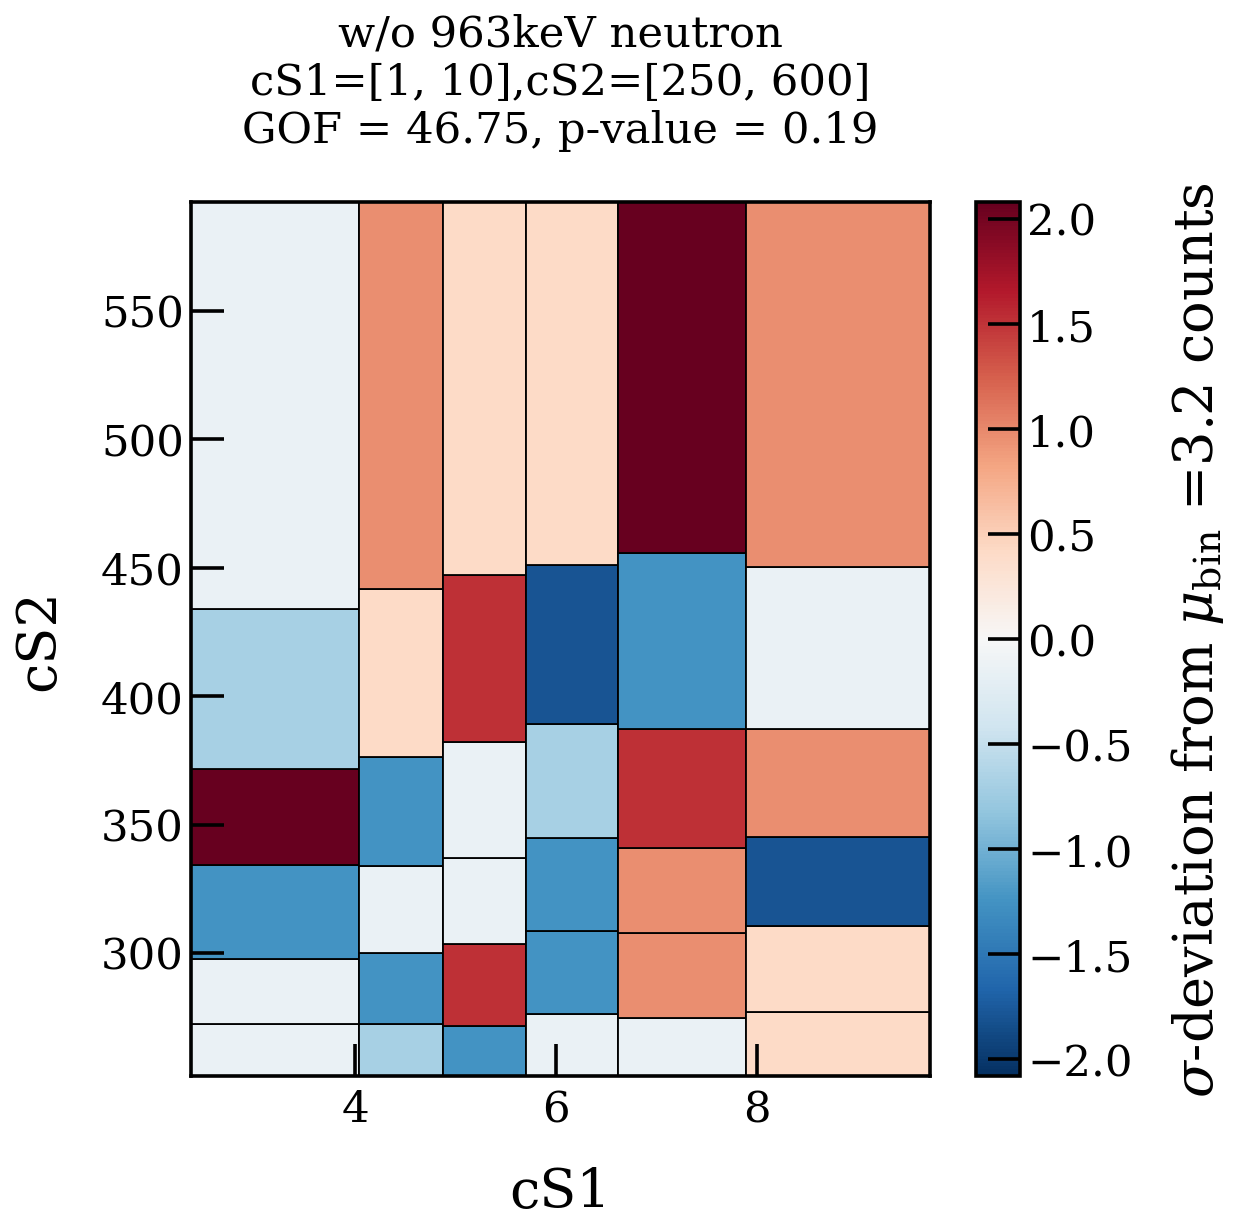

In [66]:

cs1_range=[1,10]
cs2_range=[250,600]
d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/o 963keV neutron\n')

117 123.38883357242685
GOF = 41.71
p-value = 0.3730



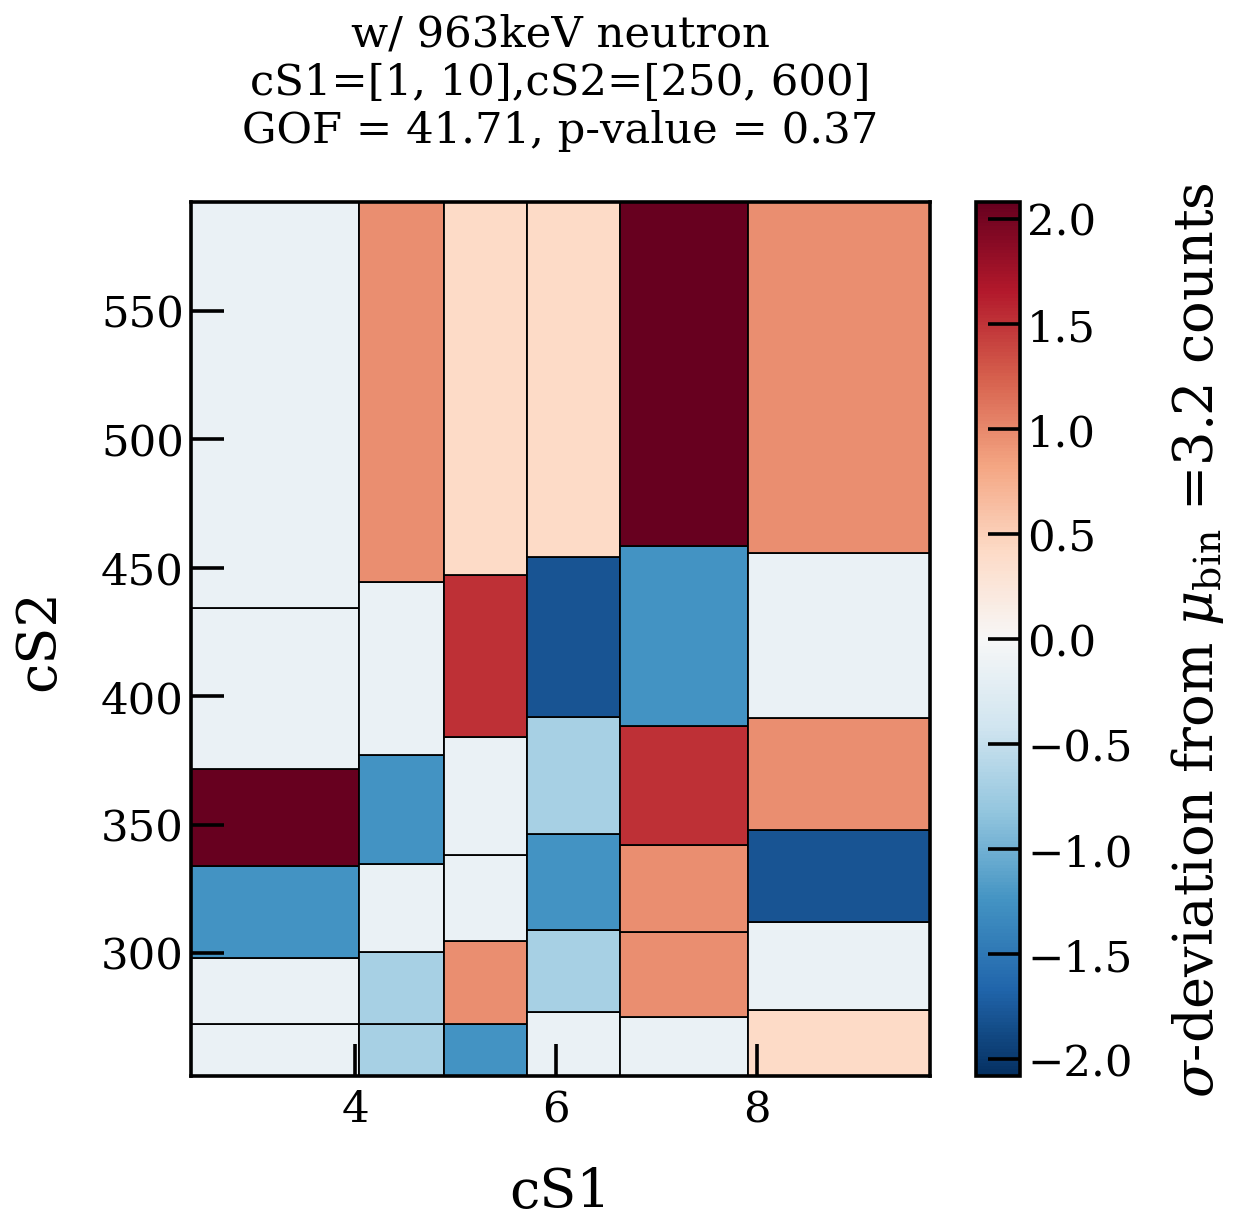

In [68]:
cs1_range=[1,10]
cs2_range=[250,600]
d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim_mixed),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/ 963keV neutron\n')

117 120.30128011526557
GOF = 46.84
p-value = 0.1800



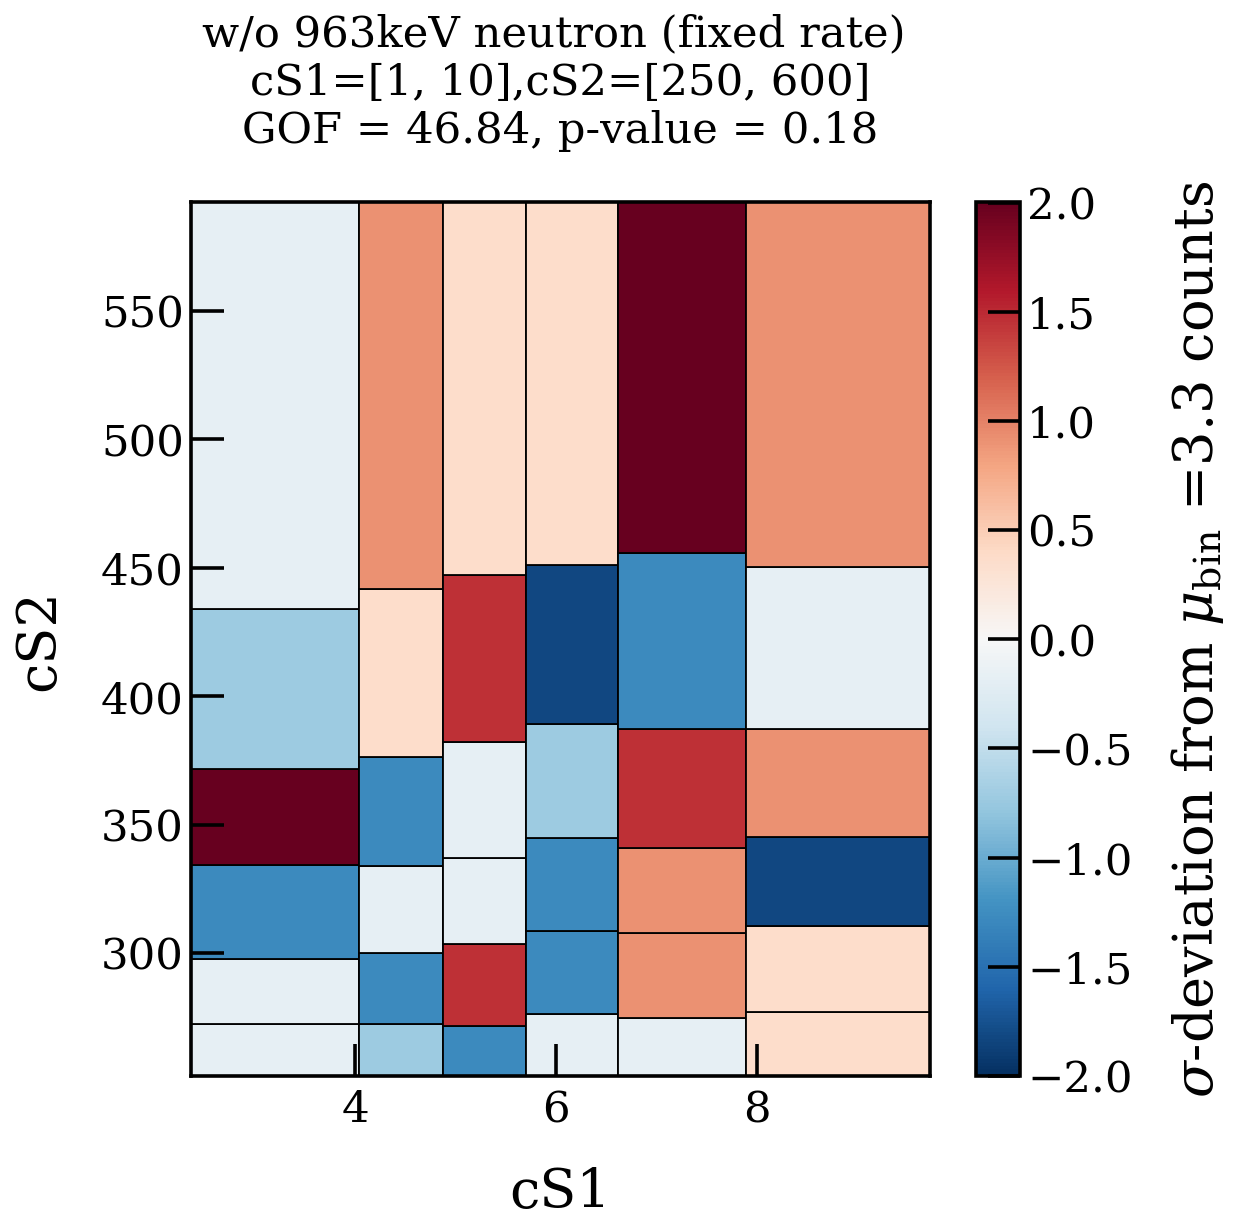

In [86]:
# cs1_range=[2.5,10]
cs1_range=[1,10]
cs2_range=[250,600]
d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/o 963keV neutron (fixed rate) \n',sim_scale=sim_s)

117 123.38883357242685
GOF = 42.05
p-value = 0.3500



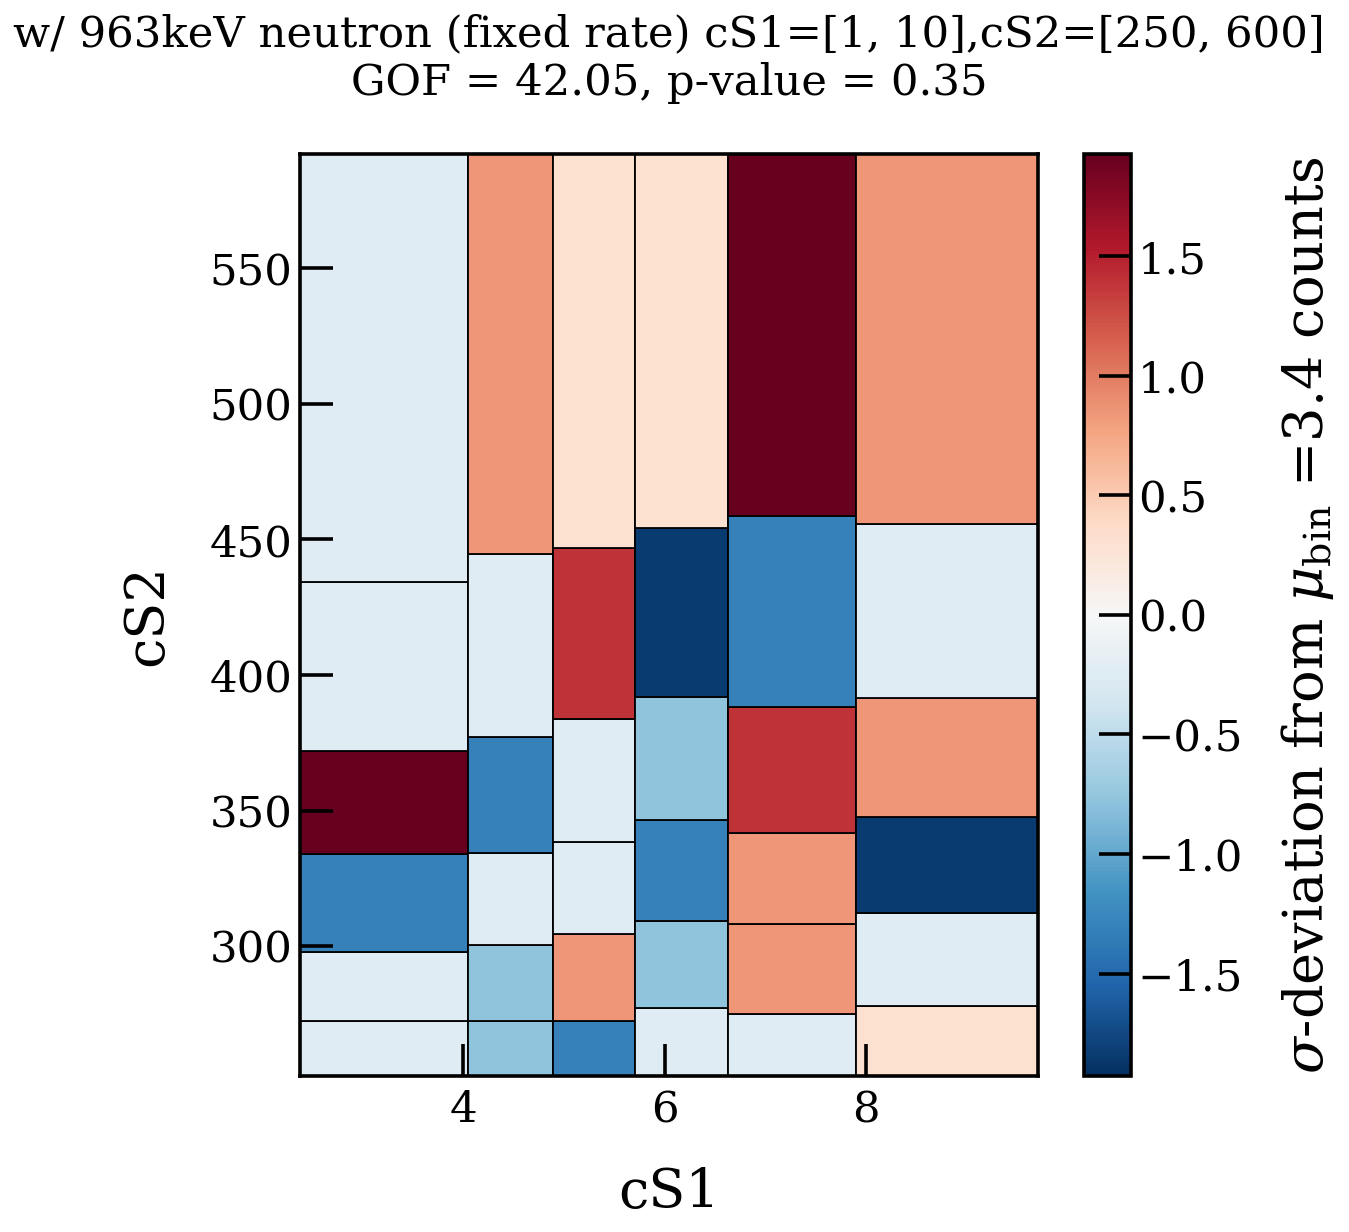

In [88]:
# cs1_range=[2.5,10]
cs1_range=[1,10]
cs2_range=[250,600]
d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim_mixed),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/ 963keV neutron (fixed rate) ',sim_scale=sim_s)

In [89]:

def GOF_equal_prob(data,sim,cs1_range,cs2_range,label='',sim_scale=None):

    data_sample=cut_cs1cs2(data,cs1=cs1_range,cs2=cs2_range)
    reference_sample=cut_cs1cs2(sim,cs1=cs1_range,cs2=cs2_range)

    data_sample=np.array(data_sample[['cs1','cs2']])
    reference_sample=np.array(reference_sample[['cs1','cs2']])
    ref_model_0=reference_sample

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    if(sim_scale==None):
        n_expectations=len(data_sample)
    else:
        n_expectations=len(reference_sample)*sim_scale
    print(len(data_sample),len(reference_sample)*sim_s )
    # define eqpb parameters
    order = [0, 1]  # [0, 1] means that first dimension 0 is binned, then dimension 1
    n_partitions = [6, 6]  # 5 partitions in dim. 0 and 6 partitions in dim. 1

    # perform GOF tests
    for i, reference_sample in enumerate([reference_sample]):
        gof_object = ge.BinnedPoissonChi2GOF.bin_equiprobable(data_sample=data_sample,
                                                              reference_sample=reference_sample,
                                                              nevents_expected=n_expectations,
                                                              n_partitions=n_partitions,
                                                              order=order,
                                                              plot=True,
                                                              ax=axes
                                                             )

        gof_object.get_pvalue()
        print(f'GOF = {gof_object.gof:.2f}')
        print(f'p-value = {gof_object.pvalue:.4f}\n')

    axes.set_title(label+f'cS1={cs1_range},cS2={cs2_range}'+'\n'+f'GOF = {gof_object.gof:.2f}, '+f'p-value = {gof_object.pvalue:.2f}\n')

    axes.set_xlabel('cS1')
    axes.set_ylabel('cS2')
    plt.tight_layout()
    plt.show()